In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column
from astropy.stats import LombScargle
import astropy.units as u                          # We'll need this later.

from astropy.io import ascii
import glob, re, copy
from hot_utils import *

from lightkurve import KeplerLightCurveFile, KeplerLightCurve

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


### Load a cool Kepler object - an oscillating star with a putative planet as found by [Sowicka et al](http://adsabs.harvard.edu/abs/2017MNRAS.467.4663S), 2017.

In [ ]:
lcs = KeplerLightCurveFile.from_archive(8197761,quarter='all',cadence='long')
quarters = np.array([])
for j, lci in enumerate(lcs):
    lci = lci.get_lightcurve('PDCSAP_FLUX').remove_nans()
    lci = lci[lci.quality==0]
    lcs[j] = lci.normalize()
    quarters = np.append(quarters,lci.quarter*np.ones_like(lci.flux))


lc = lcs[0]
lc.quarter = quarters
for lci in lcs[1:]:
    lc = lc.append(lci)

In [ ]:
pg = lc.to_periodogram(min_period=8./24.*u.day, max_period=20.*u.day)
pg.plot();


### Test the iterative sine fitting

In [ ]:
# def iterative_sine_fit(lc,nmax,min_period=4./24.*u.day, max_period=30.*u.day):
#     ff, pp, noise = [], [], []
#     y_fit = 0
#     lc2 = copy.copy(lc)

#     for j in range(nmax):
#         pg = lc2.to_periodogram(min_period=min_period, max_period=max_period)
#         best_freq = pg.frequency_at_max_power.value
#         # refine
#         for j in range(3):
#             frequency, power = LombScargle(dummy.time, dummy.flux, dummy.flux_err).autopower(minimum_frequency=best_freq*0.98,
#                                                                                              maximum_frequency=best_freq*1.08, 
#                                                                                              samples_per_peak=20)
#             best_freq = frequency[np.argmax(power)]
        
#         ff.append(best_freq)
#         pp.append(np.max(power))
#         y_fit += LombScargle(lc2.time, lc2.flux-1, lc2.flux_err).model(lc2.time, best_freq)
#         lc2.flux = lc.flux - y_fit 
#         noise.append(lc2.estimate_cdpp())
        
#     return lc2, ff, pp, noise 

In [ ]:
dummy = copy.copy(lc)



In [ ]:
dummy.flux = 1.+np.sin(dummy.time/2.)

In [ ]:
dummy.plot()

In [ ]:
frequency, power = LombScargle(dummy.time, dummy.flux, dummy.flux_err).autopower(minimum_frequency=0.01,maximum_frequency=1.9,
...                                                    samples_per_peak=10)

In [ ]:
plt.plot(frequency,power)

In [ ]:
pg = dummy.to_periodogram(min_period=8./24.*u.day, max_period=30.*u.day)
pg.plot();
print 1/pg.frequency_at_max_power


In [ ]:
toy, ff, pp, noise = iterative_sine_fit(dummy, 1, min_period=8./24., max_period=30.)    
print (1./ff[0]/2./np.pi)

In [ ]:
toy.plot()

### Can we renormalize a light curve using the sine signal?

In [ ]:
dummy = copy.copy(lc)

In [ ]:
dummy.flux = 1.+0.01*np.sin(dummy.time*2)
dummy.plot()

In [ ]:
coeffs = 0.5+0.5*np.random.rand(len(np.unique(dummy.quarter)))
for j, q in enumerate(np.unique(dummy.quarter)):
    m = (dummy.quarter == q)
    dummy.flux[m] = 1.+(dummy.flux[m]-1.)*coeffs[j]
dummy.plot()

In [ ]:
# powers = []
# freqs = []

# bestfreq, power = get_best_freq(dummy,min_period=0.5,max_period=10)

# ytest_mean = LombScargle(dummy.time, dummy.flux-1, dummy.flux_err).model(dummy.time, bestfreq)
# current = (np.max(ytest_mean)-np.min(ytest_mean))/2.
# dummy2 = copy.copy(dummy)

# for j, q in enumerate(np.unique(dummy.quarter)):
#     m = (dummy.quarter == q)

# #     bestfreq, power = get_best_freq(dummy[m],min_period=0.5,max_period=10)
#     ytest = LombScargle(dummy.time[m], dummy.flux[m]-1, dummy.flux_err[m]).model(dummy.time[m], bestfreq)
#     power = (np.max(ytest)-np.min(ytest))/2.#/np.median(dummy.flux[m])
#     dummy2.flux[m] = 1.+(dummy2.flux[m]-1.)/(power/current)

#     plt.plot(dummy.time[m],ytest)
#     powers.append(power)
#     freqs.append(bestfreq)
    


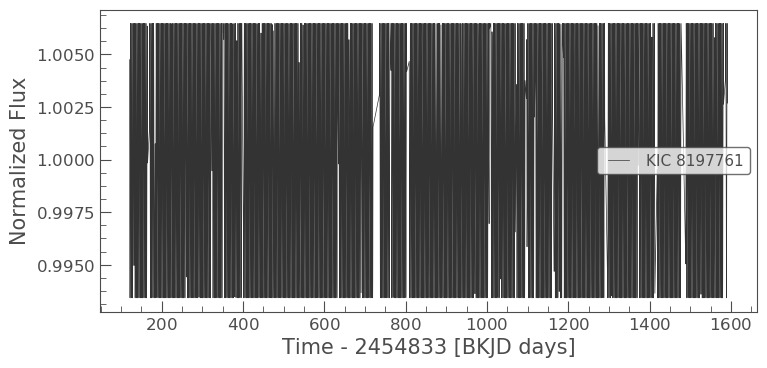

In [79]:
dummy2.plot()

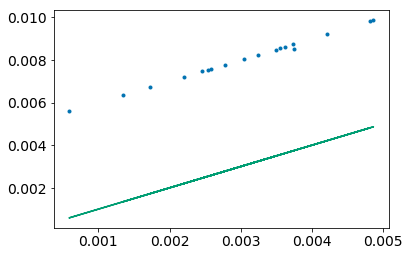

In [68]:
plt.plot((coeffs-0.5)*0.01,powers,'.')
plt.plot((coeffs-0.5)*0.01,(coeffs-0.5)*0.01,'-')


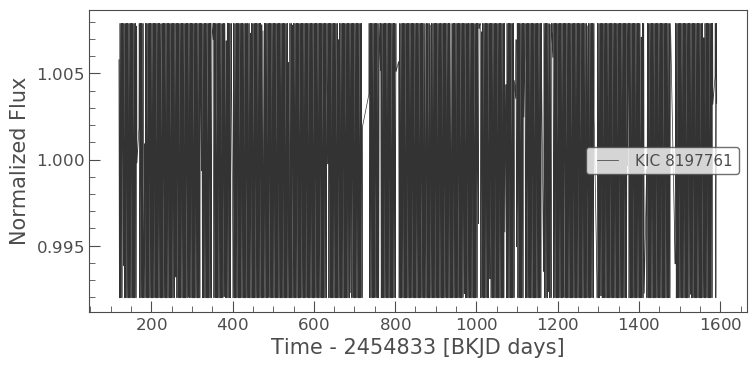

In [71]:

for j, q in enumerate(np.unique(dummy.quarter)):
    m = (dummy.quarter == q)
    dummy.flux[m] = 1.+(dummy.flux[m]-1.)/(powers[j]/current)
    
dummy.plot()

### Run an iterative sine-fitting algorithm to subtract out the stellar signal

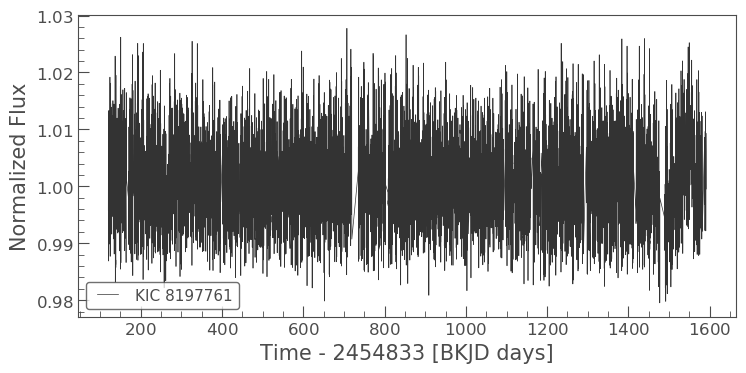

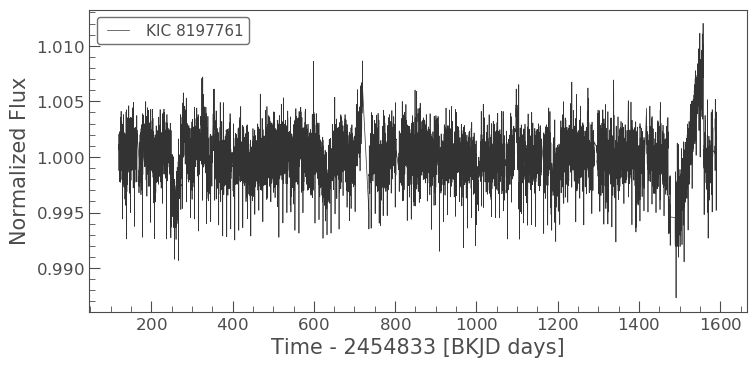

In [13]:
lc = lcs[0]
for lci in lcs[1:]:
    lc = lc.append(lci)
lc.plot()

lc2, ff, pp, noise = iterative_sine_fit(lc, 80)    
lc2.plot()

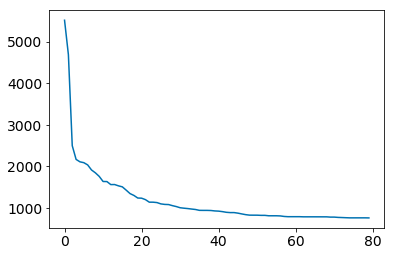

In [14]:
plt.plot(noise)

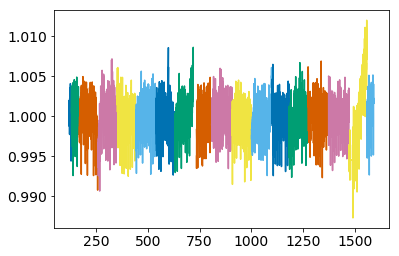

In [15]:
for q in range(18):
    m = (lc.quarter==q)
#     plt.plot(lc.time[m],lc.flux[m],'.')
    plt.plot(lc.time[m],lc2.flux[m],'-')

    

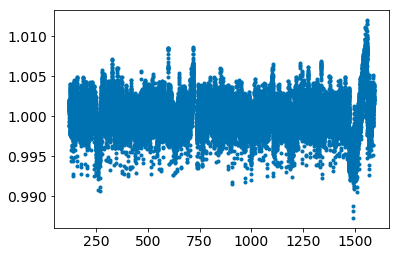

In [16]:
# lc2=lc2.flatten()
# plt.plot(lc.time,lc.flux,'.')
plt.plot(lc.time,lc2.flux,'.')

# plt.xlim(500,900)

### What does the raw light curve look like on a planet?

In [17]:
planet_period = 9.8686667
folded = lc.fold(planet_period)
binned = folded.bin(binsize=25,method='median')

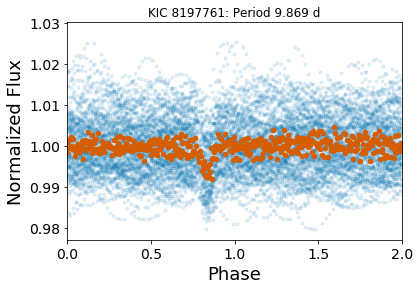

In [18]:
plt.plot(folded.phase*planet_period,folded.flux,'.',alpha=0.1)
plt.plot(binned.phase*planet_period,binned.flux,'.',markersize=9,color=colours[2])
plt.xlim(0,2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('KIC %d: Period %.3f d' % (lc.targetid,planet_period))
plt.savefig('oscillator_with_planets.png')

### Now use the Oxford systematics correction

In [19]:
lc3 = copy.copy(lc2)

for qq in np.unique(lc2.quarter.astype('int')):
    print qq
    m = lc3.quarter==qq
    lc3.flux[m] = correct_quarter(lc2,qq)
    
print 'Done'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Done


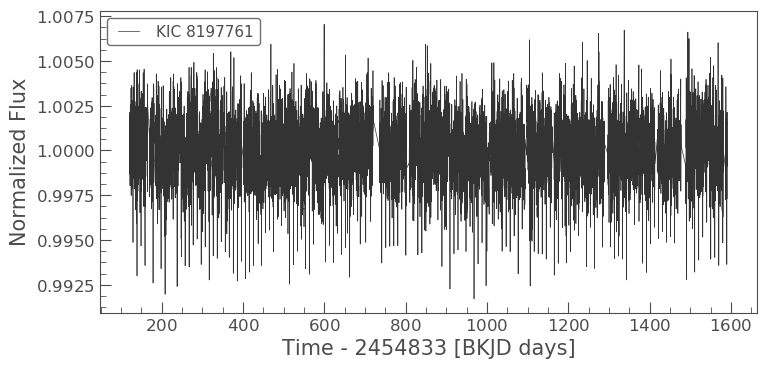

In [29]:
lc3.plot()

## Now do a BLS search to find it

In [20]:
from pybls import BLS


In [21]:
bls = BLS(lc3.time, lc3.flux, lc3.flux_err/10., period_range=(1,40), q_range=(0.001, 0.01), nf=4500, nbin=2000)


In [22]:
res = bls()

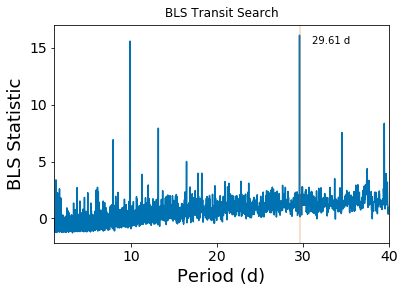

In [23]:
plt.plot(bls.period,bls.sde)
for j in range(np.round(bls.period.max()/res.bper).astype('int')):
    plt.axvline(res.bper*(j+1),alpha=0.25,color=colours[2])
plt.text(res.bper*1.05,bls.sde.max()*0.95,'%.2f d' % res.bper)
plt.xlim(bls.period.min(),bls.period.max())
plt.xlabel('Period (d)')
plt.ylabel('BLS Statistic')
plt.title('BLS Transit Search',y=1.01)
plt.savefig('bls_%d.png' %  lc.targetid)

### Now refine it

In [24]:
bls = BLS(lc3.time, lc3.flux, lc3.flux_err, period_range=(res.bper*0.98,res.bper*1.02), q_range=(0.001, 0.01), nf=4500, nbin=2000)
res = bls()

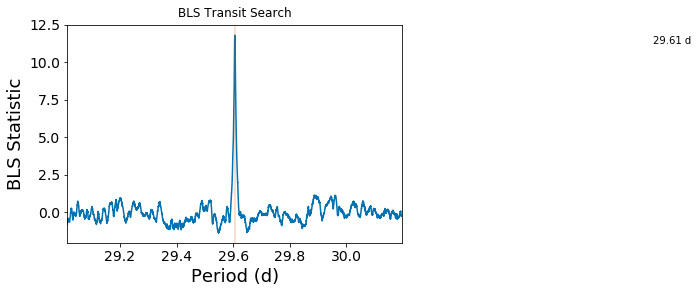

In [25]:
plt.plot(bls.period,bls.sde)
for j in range(np.round(bls.period.max()/res.bper).astype('int')):
    plt.axvline(res.bper*(j+1),alpha=0.25,color=colours[2])
plt.text(res.bper*1.05,bls.sde.max()*0.95,'%.2f d' % res.bper)
plt.xlim(bls.period.min(),bls.period.max())
plt.xlabel('Period (d)')
plt.ylabel('BLS Statistic')
plt.title('BLS Transit Search',y=1.01)
plt.savefig('bls_%d.png' %  lc.targetid)

### Plot the folded light curve

In [26]:
planet_period = 9.8686667 # literature
planet_period = res.bper/3.
folded = lc3.fold(planet_period)
binned = folded.bin(binsize=25,method='median')
folded = lc3.fold(planet_period)
binned = folded.bin(binsize=25,method='median')

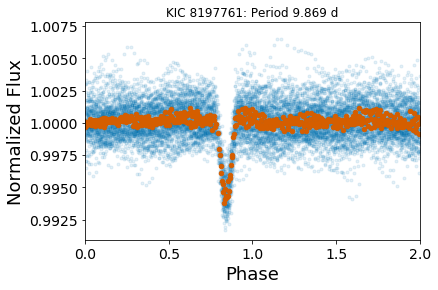

In [27]:
plt.plot(folded.phase*planet_period,folded.flux,'.',alpha=0.1)
plt.plot(binned.phase*planet_period,binned.flux,'.',markersize=9,color=colours[2])
plt.xlim(0,2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('KIC %d: Period %.3f d' % (lc.targetid,planet_period))
plt.savefig('oscillator_with_planets.png')

In [28]:
res.bper/3.

9.868625716033474